In [1]:
import numpy as np
import pandas as pd

from collections import defaultdict
from matplotlib import pyplot
from matplotlib.pyplot import figure


def read_realtives_file(path):
    relatives = pd.read_csv(path, sep='\t')
    relatives.loc[relatives.final_degree.isna(), 'final_degree'] = -1
    relatives.loc[relatives.true_degree.isna(), 'true_degree'] = -1
    relatives.final_degree = relatives.final_degree.astype(int)
    relatives.true_degree = relatives.true_degree.astype(int)
    return relatives


def precision_recall(relatives):
    metrics = {
        'tp': defaultdict(lambda: 0),
        'fn': defaultdict(lambda: 0),
        'fp': defaultdict(lambda: 0)
    }
    
    for _, row in relatives.iterrows():
        lower, upper = row.ersa_lower_bound, row.ersa_upper_bound
        degree, pred_degree = row.true_degree, row.final_degree

        if degree != -1 and pred_degree != -1:
            if degree <= 1 and pred_degree == degree:
                metrics['tp'][degree] += 1
            elif 1 < degree <= 4 and degree - 1 <= pred_degree <= degree + 1:
                metrics['tp'][degree] += 1
            elif degree > 4 and lower <= degree <= upper:
                metrics['tp'][degree] += 1
            else:
                metrics['fn'][degree] += 1
                metrics['fp'][pred_degree] += 1

        elif degree != -1 and pred_degree == -1:
            metrics['fn'][degree] += 1
        elif degree == -1 and pred_degree != -1:
            metrics['fp'][pred_degree] += 1
    
    degrees = list(range(1, relatives.true_degree.max() + 1))
    precision, recall = [], []
    for degree in degrees:
        if metrics['tp'][degree] + metrics['fp'][degree] > 0:
            precision.append(metrics['tp'][degree] / (metrics['tp'][degree] + metrics['fp'][degree]))
            recall.append(metrics['tp'][degree] / (metrics['tp'][degree] + metrics['fn'][degree]))
        else:
            precision.append(0)
            recall.append(0)
    
    return {'degrees': degrees, 'precision': precision, 'recall': recall}


def precision_recall_comparison(base_path, compare_path, title, save=False):
    base_relatives = read_realtives_file(base_path)
    compare_relatives = read_realtives_file(compare_path)
    
    base_metrics = precision_recall(base_relatives)
    compare_metrics = precision_recall(compare_relatives)
    
    degrees = np.array(base_metrics['degrees'])
    
    low_precision, precision_difference, precision_color = [], [], []
    for base_precision, compare_precision in zip(base_metrics['precision'], compare_metrics['precision']):
        low_precision.append(min(base_precision, compare_precision))
        precision_difference.append(abs(base_precision - compare_precision))
        
        if base_precision == compare_precision:
            precision_color.append('lightgray')
        else:
            precision_color.append('red' if base_precision > compare_precision else 'limegreen')

    low_recall, recall_difference, recall_color = [], [], []
    for base_recall, compare_recall in zip(base_metrics['recall'], compare_metrics['recall']):
        low_recall.append(min(base_recall, compare_recall))
        recall_difference.append(abs(base_recall - compare_recall))
        
        if base_recall == compare_recall:
            recall_color.append('lightgray')
        else:
            recall_color.append('red' if base_recall > compare_recall else 'limegreen')        
    
    fig, ax = pyplot.subplots()
    ax.bar(degrees - 0.2, low_precision, width=0.35, color='lightgray', edgecolor='lightgray', label='precision')
    ax.bar(degrees - 0.2, precision_difference, width=0.35, edgecolor=precision_color, bottom=low_precision, color=precision_color)
    
    ax.bar(degrees + 0.2, low_recall, width = 0.35, color='dimgray', edgecolor='dimgray', label='recall')
    ax.bar(degrees + 0.2, recall_difference, width=0.35, edgecolor=recall_color, bottom=low_recall, color=recall_color)

    ax.set_xticks(degrees)
    ax.legend()
    
    pyplot.ylim(0, 1.1)
    
    if title:
        pyplot.title(title)
        
    if save:
        pyplot.savefig(title + '.png')
    
    pyplot.show()
    


In [ ]:

precision_recall_comparison(
    './adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results, zsc=0.3, original mask/updated_relatives.tsv',
    './adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results-weighted, zsc=0.1/updated_relatives.tsv',
    title='original mask (zsc=0.3) | weighted (zsc=0.1)',
    save=True
)

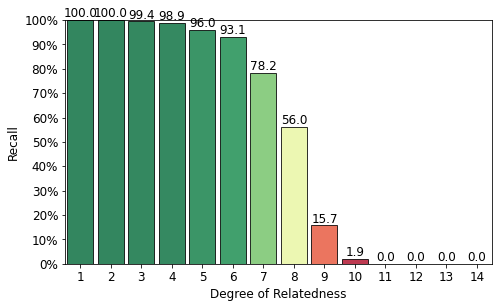

In [2]:
from matplotlib.colors import LinearSegmentedColormap

relatives = read_realtives_file(
    './adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results, zsc=0.3, original mask/updated_relatives.tsv'
)

metrics = precision_recall(relatives)
cmap = LinearSegmentedColormap.from_list('', ['red', 'yellow', 'green'])

recall = 100 * np.array(metrics['recall'])

# colors = LinearSegmentedColormap.from_list('', ['red', 'yellow', 'green'])(metrics['recall']) # v1
colors = pyplot.get_cmap("RdYlGn")(metrics['recall']) # v2

pyplot.figure(figsize=[6.8, 4])
bars = pyplot.bar(metrics['degrees'], recall, align='center', width=0.85, alpha=0.8, color=colors, edgecolor='black')

# Add counts above the two bar graphs
for bar in bars:
    height = round(bar.get_height(), 1)
    pyplot.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.1f}', ha='center', va='bottom', size='large')

pyplot.xticks(metrics['degrees'], fontsize='large')
    
yticks = np.linspace(0, 100, 11)
ylabels = [f'{tick:.0f}' + '%' for tick in yticks]
pyplot.yticks(yticks, ylabels, fontsize='large')
    
pyplot.tight_layout()
pyplot.xlim(0.5, 14.5)
pyplot.ylim(0, 100)
pyplot.xlabel('Degree of Relatedness', fontsize='large')
pyplot.ylabel('Recall', fontsize='large')
pyplot.show()

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from itertools import combinations


def create_recall_subplot(axes, metrics):
    cmap = plt.get_cmap("RdYlGn")
    bars = axes.bar(
        metrics['degrees'],
        100 * np.array(metrics['recall']),
        align='center',
        width=0.85,
        alpha=0.8,
        color=cmap(metrics['recall']),
        edgecolor='black'
    )
    
    for bar in bars:
        text = round(bar.get_height(), 1)
        text_x = bar.get_x() + bar.get_width() / 2.0
        text_y = bar.get_height()
        axes.text(
            x=text_x,
            y=text_y,
            s=f'{text:.1f}',
            ha='center',
            va='bottom',
            fontsize='small',
            color='firebrick'
        )
    
    yticks = np.linspace(0, 100, 11)
    ylabels = [f'{tick:.0f}' + '%' for tick in yticks]
    
    axes.set_yticks(yticks, ylabels, fontsize='medium')
    axes.set_xticks(metrics['degrees'], fontsize='medium')
    axes.set_xlim(0.5, 14.5)
    axes.set_ylim(0, 100)
    axes.set_xlabel('Degree of Relatedness', fontsize='large')
    axes.set_ylabel('Recall', fontsize='large')
    axes.set_axisbelow(True)


def create_precision_subplot(axes, metrics):
    cmap = pyplot.get_cmap("RdYlGn")
    bars = axes.bar(
        metrics['degrees'],
        100 * np.array(metrics['precision']),
        align='center',
        width=0.85,
        alpha=0.8,
        color=cmap(metrics['precision']),
        edgecolor='black'
    )
    
    for bar in bars:
        text = round(bar.get_height(), 1)
        text_x = bar.get_x() + bar.get_width() / 2.0
        text_y = bar.get_height()
        axes.text(
            x=text_x,
            y=text_y,
            s=f'{text:.1f}',
            ha='center',
            va='bottom',
            fontsize='small',
            color='firebrick'
        )
    
    yticks = np.linspace(0, 100, 5)
    ylabels = [f'{tick:.0f}' + '%' for tick in yticks]
    
    axes.set_yticks(yticks, ylabels, fontsize='medium')
    axes.set_xticks(metrics['degrees'], fontsize='medium')
    axes.set_xlim(0.5, 14.5)
    axes.set_ylim(0, 100)
    axes.set_xlabel('Degree of Relatedness', fontsize='large')
    axes.set_ylabel('Precision', fontsize='large')
    axes.set_axisbelow(True)


def create_confusion_metrix_subplot(axes, relatives):
    # Confusion matrix labels
    labels = relatives.true_degree.unique()
    labels = list(range(1, max(labels) + 1)) + [-1]    

    # Get all pairs of ids
    ids = set(relatives.id1) | set(relatives.id2)
    pairs = list(combinations(ids, 2))

    # Compute confusion matrix
    matrix = confusion_matrix(relatives.true_degree, relatives.final_degree, labels=labels)
    matrix[-1, -1] = len(pairs) - np.concatenate(matrix).sum()

    # Prepare for scatterplot
    xs, ys, sizes = [], [], []
    it = np.nditer(matrix, flags=['multi_index'])
    for size in it:
        xs.append(it.multi_index[0])
        ys.append(it.multi_index[1])
        sizes.append(int(size))

    # Normalize sizes
    max_size = max(sizes[:-1])
    scaled_sizes = list(map(lambda size: 200 * size / max_size, sizes))
    scaled_sizes[-1] = 250

    # Plot
    ticks = list(range(max(labels) + 1))

    axes.scatter(xs, ys, s=scaled_sizes, color='black')
    axes.set_xticks(ticks=ticks, labels=labels)
    axes.set_yticks(ticks=ticks, labels=labels)
    axes.set_xlabel('Ground truth', fontsize='large')
    axes.set_ylabel('Predicted degree', fontsize='large')

    axes.set_xlim(-1, 15)
    axes.set_ylim(-1, 15)
    axes.set_title('Confusion Matrix')
    axes.grid(color='gray', linestyle='--', linewidth=0.5)
    axes.set_axisbelow(True)
    
    for i, size in enumerate(sizes):
        if size > 0:
            axes.annotate(
                size, (xs[i], ys[i]),
                xytext=(xs[i]+0.17, ys[i]+0.29),
                fontsize='x-small',
                color='firebrick'
            )

            
def create_metric_plot(path):
    relatives = read_realtives_file(path)
    metrics = precision_recall(relatives)
    
    # Setup subplots
    gridspec = dict(width_ratios=[1.1, 1], height_ratios=[2.2, 1])
    fig, axs = pyplot.subplot_mosaic(
        [['recall', 'confusion matrix'], ['precision', 'confusion matrix']],
        gridspec_kw=gridspec, figsize=(12, 5),
        constrained_layout=True
    )
    
    create_recall_subplot(axs['recall'], metrics)
    create_precision_subplot(axs['precision'], metrics)
    create_confusion_metrix_subplot(axs['confusion matrix'], relatives)
    
    pyplot.savefig('./metrics.pdf', format='pdf')
    pyplot.show()

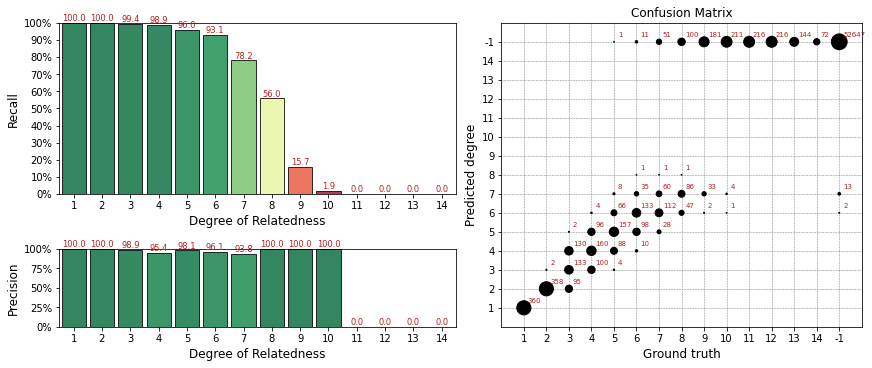

In [4]:
create_metric_plot('./adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results, zsc=0.3, original mask/updated_relatives.tsv')

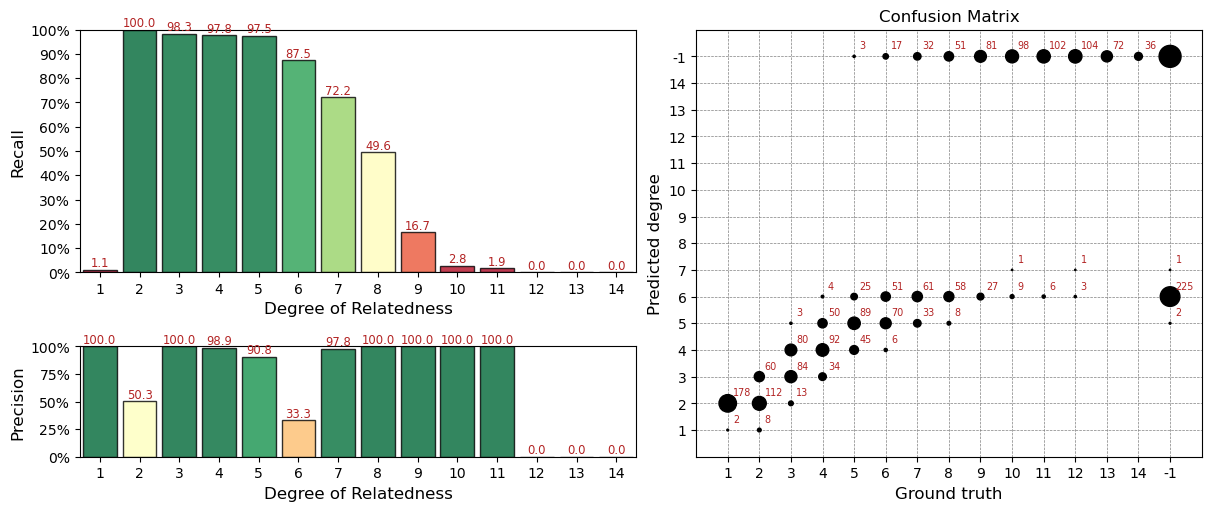

In [5]:
create_metric_plot('../workdir/runs/simulate_rapid_average/results/updated_relatives.tsv')


## Plot Metrics for TRIBES Results

In [5]:
import pandas as pd


def read_tribes_relatives_file(path):
    relatives = pd.read_csv(path, sep=',')
    relatives.loc[relatives.EstDegree == "PO", "EstDegree"] = "1"
    relatives.EstDegree = relatives.EstDegree.astype(int)
    return relatives

grape = read_realtives_file('./tribes/grape.tsv')
tribes = read_tribes_relatives_file('./tribes/tribes.csv')
print(grape.shape, tribes.shape)

(1809, 16) (12074, 6)


In [6]:
from itertools import combinations


ids = set(grape.id1) | set(grape.id2)
len(list(combinations(ids, 2))) - 12074

1954

In [7]:
grape.head(1)

,id1,id2,king_degree,king_relation,shared_genome_proportion,kinship,kinship_degree,ersa_degree,ersa_lower_bound,ersa_upper_bound,is_niece_aunt,final_degree,total_seg_len,total_seg_len_ibd2,seg_count,true_degree
0,first1_g1-b1-i1,first1_g2-b1-i1,1.0,PO,0.4997,0.2483,1.0,1.0,1.0,2.0,False,1,3372.655379,0.0,40.0,1


In [8]:
tribes['index'] = tribes.Id1 + ':' + tribes.Id2
tribes.head()

,Id1,Id2,IBD0.cM,IBD1.cM,IBD2.cM,EstDegree,index
0,first1_g1-b1-s1,first1_g1-b1-i1,0.999027,NaN,NaN,11,first1_g1-b1-s1:first1_g1-b1-i1
1,first1_g1-b1-i1,first1_g2-b1-i1,0.002731,NaN,NaN,1,first1_g1-b1-i1:first1_g2-b1-i1
2,first1_g1-b1-s1,first1_g2-b1-i1,0.002823,NaN,NaN,1,first1_g1-b1-s1:first1_g2-b1-i1
3,first1_g2-b1-s1,first1_g2-b1-i1,0.997927,NaN,NaN,10,first1_g2-b1-s1:first1_g2-b1-i1
4,first1_g1-b1-i1,first1_g2-b1-s1,0.997390,NaN,NaN,10,first1_g1-b1-i1:first1_g2-b1-s1


In [9]:
merge = pd.merge(tribes, grape, left_on = ['Id1','Id2'], right_on = ['id1','id2'], how='left')
merge = merge[['Id1', 'Id2', 'EstDegree', 'true_degree']]
merge.loc[merge.true_degree.isna(), 'true_degree'] = -1
merge.true_degree = merge.true_degree.astype(int)
merge.columns = ['id1', 'id2', 'final_degree', 'true_degree']
merge.head()

,id1,id2,final_degree,true_degree
0,first1_g1-b1-s1,first1_g1-b1-i1,11,-1
1,first1_g1-b1-i1,first1_g2-b1-i1,1,1
2,first1_g1-b1-s1,first1_g2-b1-i1,1,1
3,first1_g2-b1-s1,first1_g2-b1-i1,10,-1
4,first1_g1-b1-i1,first1_g2-b1-s1,10,-1


In [10]:
def tribes_degree_to_interval(degree):
    interval_map = {
        1: (1, 1), 2: (2, 3),3: (2, 4),
        4: (3, 5), 5: (4, 7), 6: (4, 8),
        7: (5, 10), 8: (5, 11), 9: (5, 13),
        10: (6, 14), 11: (7, 14), 12: (7, 14),
        13: (7, 14), 14: (7, 14)
    }
    lower = interval_map[degree][0]
    upper = interval_map[degree][1]
    return lower, upper


def tribes_degree_to_lower(degree):
    return tribes_degree_to_interval(degree)[0]


def tribes_degree_to_upper(degree):
    return tribes_degree_to_interval(degree)[1]

In [11]:
merge['ersa_lower_bound'] = merge.apply(lambda row: tribes_degree_to_lower(row.final_degree), axis=1)
merge['ersa_upper_bound'] = merge.apply(lambda row: tribes_degree_to_upper(row.final_degree), axis=1)
merge.head()

,id1,id2,final_degree,true_degree,ersa_lower_bound,ersa_upper_bound
0,first1_g1-b1-s1,first1_g1-b1-i1,11,-1,7,14
1,first1_g1-b1-i1,first1_g2-b1-i1,1,1,1,1
2,first1_g1-b1-s1,first1_g2-b1-i1,1,1,1,1
3,first1_g2-b1-s1,first1_g2-b1-i1,10,-1,6,14
4,first1_g1-b1-i1,first1_g2-b1-s1,10,-1,6,14


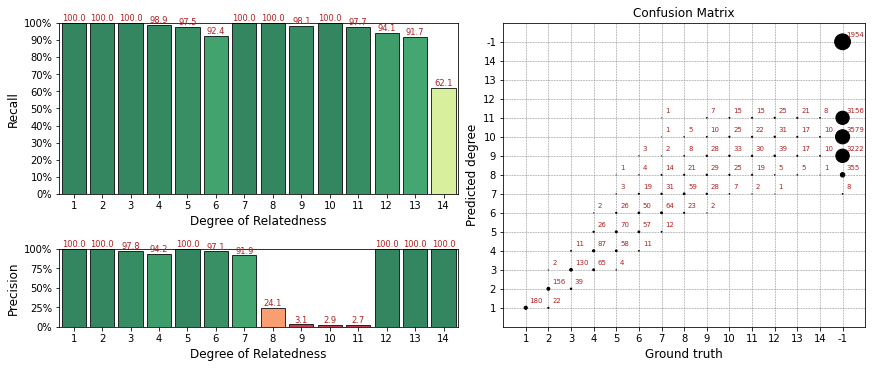

In [12]:
def create_tribes_metric_plot(relatives):
    metrics = precision_recall(relatives)
    
    # Setup subplots
    gridspec = dict(width_ratios=[1.1, 1], height_ratios=[2.2, 1])
    fig, axs = pyplot.subplot_mosaic(
        [['recall', 'confusion matrix'], ['precision', 'confusion matrix']],
        gridspec_kw=gridspec, figsize=(12, 5),
        constrained_layout=True
    )
    
    create_recall_subplot(axs['recall'], metrics)
    create_precision_subplot(axs['precision'], metrics)
    create_confusion_metrix_subplot(axs['confusion matrix'], relatives)
    
    pyplot.savefig('./tribes_metrics.pdf', format='pdf')
    pyplot.show()

create_tribes_metric_plot(merge)

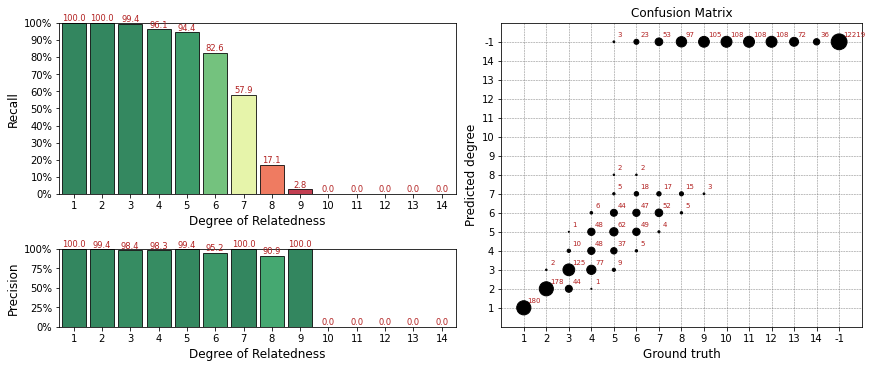

In [13]:
create_metric_plot('./tribes/grape.tsv')

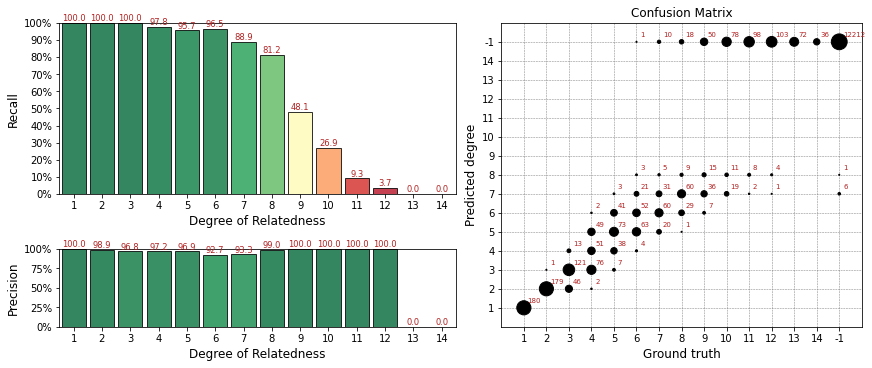

In [14]:
create_metric_plot('./GRAPE Article Visualisations/data/grape-ibis-king-relaxed.tsv')

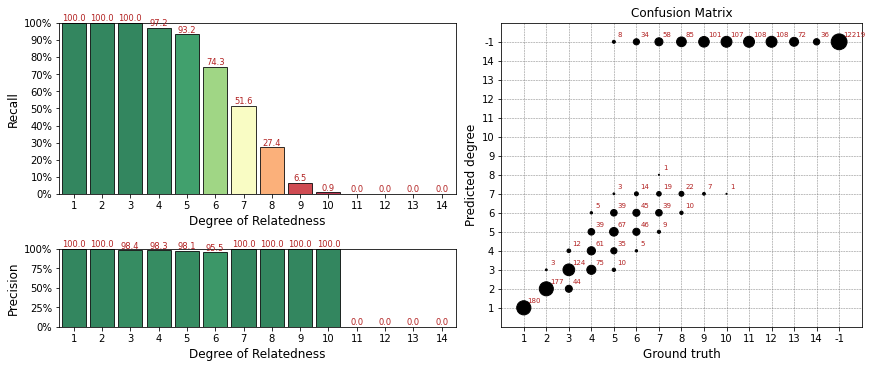

In [16]:
create_metric_plot('./GRAPE Article Visualisations/data/germline-king.tsv')

## Performance Plot

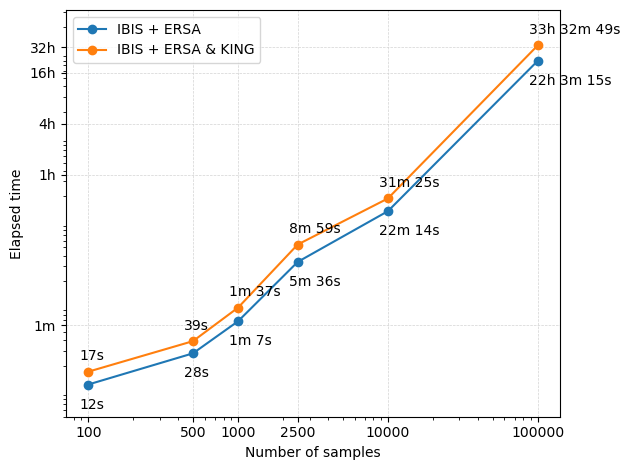

finished


In [2]:
import datetime
import matplotlib.pyplot as plt

from time import strftime
from time import gmtime
from matplotlib import markers


samples = [100, 500, 1000, 2500, 10000, 100000]
ibis = [12, 28, 1*60 + 7, 5*60 + 36, 22*60 + 14, 22*3600 + 3*60 + 15]
ibis_king = [17, 39, 1*60 + 37, 8*60 + 59, 31*60 + 25, 33*3600 + 32*60 + 49]
# rapid = [0, 0, 6*60+3, 0, 0, 0]
# 0:06:03
def seconds_to_string(seconds):
    if seconds < 60:
        return strftime("%-Ss", gmtime(seconds))
    elif seconds < 3600:
        return strftime("%-Mm %-Ss", gmtime(seconds))
    else:
        return "%sh %sm %ss" % (seconds // 3600, (seconds % 3600) // 60, seconds % 60)

ibis_labels = list(map(seconds_to_string, ibis))
ibis_king_labels = list(map(seconds_to_string, ibis_king))

for i, xy in enumerate(zip(samples, ibis)):
    x, y = xy
    plt.annotate(ibis_labels[i], xy=(x / (10 ** 0.06), y / (10 ** 0.32)),
                 horizontalalignment='left', verticalalignment='bottom')
    
for i, xy in enumerate(zip(samples, ibis_king)):
    x, y = xy
    plt.annotate(ibis_king_labels[i], xy=(x / (10 ** 0.06), y * (10 ** 0.1)),
                 horizontalalignment='left', verticalalignment='bottom')

plt.plot(samples, ibis, 'o-')
plt.plot(samples, ibis_king, 'o-')
plt.yscale('log')
plt.xscale('log')
plt.ylim(5, 10 ** 5.5)
plt.xlabel('Number of samples')
plt.ylabel('Elapsed time')
plt.legend(['IBIS + ERSA', 'IBIS + ERSA & KING'])
plt.xticks(samples, samples)
plt.yticks([60, 3600, 4 * 3600, 16 * 3600, 32 * 3600], ['1m', '1h', '4h', '16h', '32h'])
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('performance.pdf')
plt.show()
print(f'finished')

## Mask / Weights Comparison

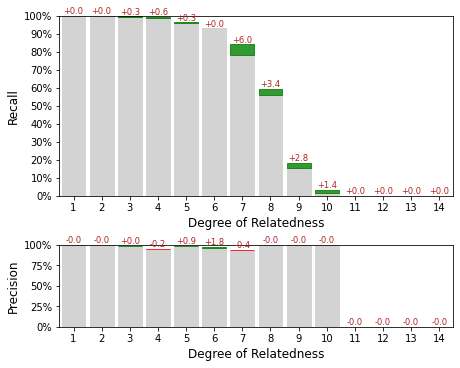

In [5]:
base_path = './adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results, zsc=0.3, original mask/updated_relatives.tsv'
base_relatives = read_realtives_file(base_path)
base_metrics = precision_recall(base_relatives)

compare_path = './adjusting-ibd-segments-length/report/(6) Simulation, East Asian Ancestry/results-weighted, zsc=0.1/updated_relatives.tsv'
compare_relatives = read_realtives_file(compare_path)
compare_metrics = precision_recall(compare_relatives)

# Setup subplots
gridspec = dict(width_ratios=[1], height_ratios=[2.2, 1])
fig, axs = pyplot.subplot_mosaic(
    [['recall'], ['precision']],
    gridspec_kw=gridspec, figsize=(6.28, 5),
    constrained_layout=True
)

# RECALL

low_recall, recall_difference, recall_color = [], [], []
for base_recall, compare_recall in zip(base_metrics['recall'], compare_metrics['recall']):
    low_recall.append(min(base_recall, compare_recall))
    recall_difference.append(abs(base_recall - compare_recall))

    if base_recall == compare_recall:
        recall_color.append('lightgray')
    else:
        recall_color.append('red' if base_recall > compare_recall else 'green')        

low_recall = 100 * np.array(low_recall)
recall_difference = 100 * np.array(recall_difference)

axs['recall'].bar(
    base_metrics['degrees'],
    low_recall,
    width = 0.85,
    align='center',
    alpha=1,
    color='lightgray',
    edgecolor='lightgray',
    label='recall'
)

bars = axs['recall'].bar(
    base_metrics['degrees'],
    recall_difference,
    width = 0.85,
    align='center',
    alpha=0.8,
    edgecolor=recall_color,
    bottom=low_recall,
    color=recall_color
)

for i, bar in enumerate(bars):
    value = round(recall_difference[i], 1)
    text = ('+' + f'{value:.1f}') if value >= 0 else ('-' + f'{value:.1f}')
    text_x = bar.get_x() + bar.get_width() / 2.0
    text_y = bar.get_y() + bar.get_height()
    axs['recall'].text(
        x=text_x,
        y=text_y,
        s=text,
        ha='center',
        va='bottom',
        fontsize='small',
        color='firebrick'
    )

yticks = np.linspace(0, 100, 11)
ylabels = [f'{tick:.0f}' + '%' for tick in yticks]

axs['recall'].set_yticks(yticks, ylabels, fontsize='medium')
axs['recall'].set_xticks(base_metrics['degrees'], fontsize='medium')
axs['recall'].set_xlim(0.5, 14.5)
axs['recall'].set_ylim(0, 100)
axs['recall'].set_xlabel('Degree of Relatedness', fontsize='large')
axs['recall'].set_ylabel('Recall', fontsize='large')
axs['recall'].set_axisbelow(True)

# PRECISION

low_precision, precision_difference, precision_color = [], [], []
for base_precision, compare_precision in zip(base_metrics['precision'], compare_metrics['precision']):
    low_precision.append(min(base_precision, compare_precision))
    precision_difference.append(abs(base_precision - compare_precision))

    if base_precision == compare_precision:
        precision_color.append('lightgray')
    else:
        precision_color.append('red' if base_precision > compare_precision else 'green')

low_precision = 100 * np.array(low_precision)
precision_difference = 100 * np.array(precision_difference)

axs['precision'].bar(
    base_metrics['degrees'],
    low_precision,
    width = 0.85,
    align='center',
    alpha=1,
    color='lightgray',
    edgecolor='lightgray',
    label='recall'
)

bars = axs['precision'].bar(
    base_metrics['degrees'],
    precision_difference,
    width = 0.85,
    align='center',
    alpha=0.8,
    edgecolor=precision_color,
    bottom=low_precision,
    color=precision_color
)

for i, bar in enumerate(bars):
    value = round(precision_difference[i], 1)
    text = ('+' + f'{value:.1f}') if precision_color[i] == 'green' else ('-' + f'{value:.1f}')
    text_x = bar.get_x() + bar.get_width() / 2.0
    text_y = bar.get_y() + bar.get_height()
    axs['precision'].text(
        x=text_x,
        y=text_y,
        s=text,
        ha='center',
        va='bottom',
        fontsize='small',
        color='firebrick'
    )

yticks = np.linspace(0, 100, 5)
ylabels = [f'{tick:.0f}' + '%' for tick in yticks]

axs['precision'].set_yticks(yticks, ylabels, fontsize='medium')
axs['precision'].set_xticks(base_metrics['degrees'], fontsize='medium')
axs['precision'].set_xlim(0.5, 14.5)
axs['precision'].set_ylim(0, 100)
axs['precision'].set_xlabel('Degree of Relatedness', fontsize='large')
axs['precision'].set_ylabel('Precision', fontsize='large')
axs['precision'].set_axisbelow(True)

plt.savefig('weighing.pdf')
